# 1. Business Understanding

## 1.2 Problem Statement

Many investors, lenders, and business owners rely on intuition or outdated reports when evaluating a company’s financial position. This lack of real-time, data-driven analysis can lead to poor investment or lending decisions.

Our challenge is to develop a **data-powered tool** that automatically analyzes publicly available financial data (like income statements, balance sheets, and cash flows) to assess a company’s **financial stability, profitability, and risk**.

This project will simplify financial decision-making by transforming raw numbers into actionable insights through **data analysis, visualization, and machine learning**.

---

## 1.3 Business Objectives

### Main Objective

To build a **data analysis and scoring system** that evaluates a company’s financial health using real-world financial data.

### Specific Objectives

1. To collect and preprocess financial data from **Yahoo Finance API**  
2. To analyze key financial metrics such as revenue growth, net income, debt-to-equity ratio, and cash flow trends.  
3. To build a **financial health scoring model** that assigns a score to each company based on performance indicators.  
4. To visualize financial insights using clear dashboards and charts for easier interpretation.  
5. To provide actionable recommendations for investors or business managers.

---

## 1.4 Research Questions

1. What financial indicators most accurately represent a company’s health and stability?  
2. How do profitability, liquidity, and leverage ratios correlate with a company’s risk level?  
3. Can we build a model that classifies companies into categories such as _Healthy_, _Moderate_, and _At Risk_?  
4. How can visualizing financial trends help investors make better decisions?

---

## 1.5 Success Criteria

- The system should accurately collect and clean financial data for multiple companies.  
- It should compute and visualize key financial ratios and trends.  
- The scoring model should produce realistic health scores based on financial fundamentals.  
- The final output should be clear and explainable to both technical and non-technical users.

---

# 2. Data Understanding

We will use **real financial datasets** fetched directly from APIs — not from Kaggle.

---

## Datasets & Sources

| Source | Type of Data | Description |
| --- | --- | --- |
| **Yahoo Finance API (via yfinance)** | Company financials | Income statements, balance sheets, cash flow, and stock history |
---

## Dataset Overview

Each company dataset will include:

- **Revenue**  
- **Gross profit**  
- **Operating income**  
- **Net income**  
- **Total assets & liabilities**  
- **Cash flow from operations**  
- **Debt-to-equity ratio**  
- **Return on assets (ROA)** and **Return on equity (ROE)**  
- **Stock price performance** over time  

These metrics help us assess profitability, liquidity, leverage, and efficiency — the four main pillars of financial health.

---

## Tools and Libraries

We’ll use the following tools for the analysis:

| Category | Libraries |
| --- | --- |
| **Data Collection** | `yfinance`, `requests`, `pandas` |
| **Data Cleaning & Processing** | `numpy`, `pandas` |
| **Visualization** | `matplotlib`, `seaborn`, `plotly` |
| **Modeling & Scoring** | `scikit-learn`, `statsmodels` |
| **Deployment (Optional)** | `joblib` for model serialization |


# 3. Data Preparation

In this section, we will import the necessary Python libraries and load financial data directly from Yahoo Finance using the `yfinance` API. This will form the foundation of our analysis.

The data will include income statements, balance sheets, cash flow statements, and stock price history for a chosen company. We will then explore its structure before cleaning and feature engineering.


In [1]:
# Create requirements.txt 
import os

req_content = """
yfinance>=0.2.66
pandas-datareader
openpyxl
pandas>=1.3.0
numpy>=1.16.5
scikit-learn
matplotlib
seaborn
tqdm
difflib
"""

# Save in current notebook directory
with open("requirements.txt", "w") as f:
    f.write(req_content.strip())

print("requirements.txt created in:", os.getcwd())

requirements.txt created in: C:\Users\Admin


## 1. Imports – Core Libraries (Security & Scalability Review)

**Purpose**: Load all dependencies for financial data ingestion, analysis, ML modeling, and visualization.  
**Why it matters**: Ensures **no runtime `ImportError`** and a **modular design**    
**Scalability Note**: `tqdm` enables progress tracking; `pickle` for caching (TTL-aware).  
**Precision Note**: `numpy` used only for arrays – **all money values will use `Decimal` later**.


In [2]:
# 1. Imports
!pip install shap
!pip install xgboost
!pip install imbalanced-learn
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web   
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, auc, accuracy_score
)
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from itertools import cycle
import shap
from tqdm import tqdm
import os, pickle, time
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor, IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("All libraries imported.")

All libraries imported.


## 2. Build Ticker Universe

**Purpose**: Create a **large, clean list of investable tickers** for financial statement extraction.  
**Sources**:  
- **NASDAQ**: Official symbols via `pandas_datareader` (no FTP, no 403)  
- **S&P 500**: Public CSV from GitHub (no Wikipedia scraping)  
**Filter**: `marketCap ≥ $100M` → ensures data availability + financial relevance  
**Fallbacks**: Hardcoded top-10 list if APIs fail → **pipeline never crashes**  
**Scalability**: Limits to 15,000 checks → avoids rate-limiting; caps final list at 12,000  
**Security**: Public read-only sources. No credentials.  

In [4]:
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols 

# 1. Get S&P 500 tickers (from public CSV)
def get_sp500_tickers():
    url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/main/data/constituents.csv"
    try:
        sp500 = pd.read_csv(url)
        return sp500['Symbol'].str.replace('.', '-').tolist()
    except Exception as e:
        print(f"S&P 500 fetch failed: {e}. Using fallback.")
        return ['AAPL','MSFT','GOOGL','AMZN','NVDA','META','TSLA','BRK-B','LLY','AVGO']

# 2. Get NASDAQ tickers
def get_nasdaq_tickers():
    try:
        nasdaq = get_nasdaq_symbols()
        return nasdaq['NASDAQ Symbol'].dropna().tolist()
    except Exception as e:
        print(f"NASDAQ fetch failed: {e}. Using fallback.")
        return ['AAPL','MSFT','GOOGL','AMZN','NVDA','META','TSLA','AVGO','ASML','PEP']

# 3. Combine and dedupe
sp500 = get_sp500_tickers()
nasdaq = get_nasdaq_tickers()
all_tickers = list(set(sp500 + nasdaq))
print(f"Total raw tickers: {len(all_tickers):,}")

# 4. Cache setup
CACHE_DIR = Path.cwd() / "cache"
CACHE_DIR.mkdir(exist_ok=True)
CACHE_FILE = CACHE_DIR / "ticker_universe.pkl"

# 5. Load from cache 
if CACHE_FILE.exists():
    ticker_symbols = pickle.load(open(CACHE_FILE, "rb"))
    print(f"Loaded cached universe: {len(ticker_symbols):,} tickers")
else:
    # 6. ONE API CALL: Bulk download
    print("Bulk downloading market data (1 request)...")
    data = yf.download(
        tickers=all_tickers,
        period="5d",
        interval="1d",
        group_by='ticker',
        auto_adjust=True,
        threads=True,
        progress=True
    )

    # 7. Extract market cap
    print("Extracting market caps...")
    market_caps = {}
    for t in all_tickers:
        try:
            market_caps[t] = yf.Ticker(t).info.get('marketCap', 0)
        except:
            market_caps[t] = 0

    # 8. Filter: $100M+
    min_cap = 100_000_000
    valid = [t for t, cap in market_caps.items() if cap >= min_cap]
    ticker_symbols = valid[:12_000]  # safety cap

    # 9. Save cache
    pickle.dump(ticker_symbols, open(CACHE_FILE, "wb"))
    print(f"Saved cache → {CACHE_FILE}")

print(f"Final universe: {len(ticker_symbols):,} tickers")

NASDAQ fetch failed: read_csv() takes 1 positional argument but 2 positional arguments (and 3 keyword-only arguments) were given. Using fallback.
Total raw tickers: 504
Loaded cached universe: 503 tickers
Final universe: 503 tickers


## 3. Financial Statement Mapping 

**Purpose**: Define **standardized, readable field names** for key financial metrics while mapping to **exact Yahoo Finance row labels**.  
**Why it matters**: Enables **consistent ratio calculations** across 10,000+ tickers despite naming inconsistencies.  
**Structure**:  
- **Key** = clean, analyst-friendly name  
- **Value** = exact string from `yf.Ticker().financials` / `.balance_sheet` / `.cash_flow`  
**Finance Context**: Focuses on **core profitability, liquidity, and cash flow** drivers.  
**Scalability Note**: Will be used with **fuzzy matching** later → robust to label changes.


In [5]:
# 3. Desired items 
income_items = {
    "Total Revenue": "Total Revenue",
    "Gross Profit": "Gross Profit",
    "Operating Income": "Operating Income",
    "Net Income": "Net Income"
}

balance_items = {
    "Total Assets": "Total Assets",
    "Total Liab": "Total Liabilities",
    "Total Stockholder Equity": "Stockholders Equity",
    "Cash": "Cash and Cash Equivalents"
}

cash_flow_items = {
    "Total Cash From Operating Activities": "Operating Cash Flow",
    "Capital Expenditures": "CapEx",
    "Total Cash From Financing Activities": "Financing Cash Flow",
    "Total Cash From Investing Activities": "Investing Cash Flow"
}

In [6]:
# Combine all mappings
item_mapping = {**income_items, **balance_items, **cash_flow_items}

print("Financial statement mapping defined:")
for clean, raw in list(item_mapping.items())[:5]:
    print(f"  {clean} → '{raw}'")
print("  ...")

# Reuse or recompute market_caps + sectors
def safe_get_info(ticker, field, default='Unknown'):
    """Safely get info field with retry + fallback"""
    try:
        return yf.Ticker(ticker).info.get(field, default)
    except:
        return default

# Reuse market_caps 
try:
    market_caps  
    sectors        
except NameError:
    print("Extracting market caps & sectors (safe mode)...")
    market_caps = {}
    sectors = {}
    for t in tqdm(all_tickers, desc="Info"):
        market_caps[t] = safe_get_info(t, 'marketCap', 0)
        sectors[t] = safe_get_info(t, 'sector', 'Unknown')

# Full universe stats
full_df = pd.DataFrame([
    {'Ticker': t, 'MarketCap': cap} for t, cap in market_caps.items()
])
full_df = full_df[full_df['MarketCap'] > 0].sort_values('MarketCap', ascending=False)

# Your 503
small_universe = ticker_symbols
small_df = full_df[full_df['Ticker'].isin(small_universe)]

# 3. Top 20 missing (by cap)
missing = full_df[~full_df['Ticker'].isin(small_universe)].head(20)
print("\n=== TOP 20 MISSING TICKERS (by market cap) ===")
print(missing[['Ticker', 'MarketCap']].to_string(index=False, formatters={'MarketCap':lambda x: '${:,.0f}'}))

# 4. Market cap coverage
total_cap_full = full_df['MarketCap'].sum()
total_cap_small = small_df['MarketCap'].sum()
coverage = total_cap_small / total_cap_full * 100 if total_cap_full > 0 else 0

print(f"\nMARKET CAP COVERAGE ")
print(f"Full universe:  {len(full_df):,} tickers → ${total_cap_full:,.0f}")
print(f"Your 503:       {len(small_df):,} tickers → ${total_cap_small:,.0f}")
print(f"Coverage:       {coverage:.1f}% of total market cap")

# 5. Sector diversity (reused from above)
full_sectors = pd.Series([sectors.get(t, 'Unknown') for t in full_df['Ticker']]).value_counts()
small_sectors = pd.Series([sectors.get(t, 'Unknown') for t in small_df['Ticker']]).value_counts()

print(f"\nSECTOR DIVERSITY")
print("Full universe sectors:")
print(full_sectors.head(10))
print("\nYour 503 sectors:")
print(small_sectors.head(10))

Financial statement mapping defined:
  Total Revenue → 'Total Revenue'
  Gross Profit → 'Gross Profit'
  Operating Income → 'Operating Income'
  Net Income → 'Net Income'
  Total Assets → 'Total Assets'
  ...
Extracting market caps & sectors (safe mode)...


Info:   4%|▎         | 18/504 [00:36<15:47,  1.95s/it]HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}
HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}
Info: 100%|██████████| 504/504 [16:30<00:00,  1.97s/it]


=== TOP 20 MISSING TICKERS (by market cap) ===
Empty DataFrame
Columns: [Ticker, MarketCap]
Index: []

MARKET CAP COVERAGE 
Full universe:  503 tickers → $64,563,780,182,272
Your 503:       503 tickers → $64,563,780,182,272
Coverage:       100.0% of total market cap

SECTOR DIVERSITY
Full universe sectors:
Technology                83
Industrials               71
Financial Services        68
Healthcare                60
Consumer Cyclical         56
Consumer Defensive        37
Utilities                 31
Real Estate               31
Communication Services    24
Energy                    22
Name: count, dtype: int64

Your 503 sectors:
Technology                83
Industrials               71
Financial Services        68
Healthcare                60
Consumer Cyclical         56
Consumer Defensive        37
Utilities                 31
Real Estate               31
Communication Services    24
Energy                    22
Name: count, dtype: int64


## 4.Function: `resolve_item_names`

The `resolve_item_names` function attempts to intelligently match a list of *desired* item names against the index of a given Pandas DataFrame. It supports exact, case-insensitive, and fuzzy string matching to handle inconsistent or imperfect naming across datasets.

**Purpose:**  
To map each desired raw name to the most appropriate actual name found in the DataFrame index.

**Key Features:**
- Handles `None` or empty DataFrames gracefully.
- Performs:
  - Exact matches  
  - Case-insensitive matches  
  - Fuzzy matches (via `difflib.get_close_matches`)
- Optionally prints detailed match logs when `verbose=True`.
- Warns if overall match accuracy is below 80%.

**Returns:**  
A dictionary mapping each desired name to its resolved actual name (or `None` if no match is found).


In [7]:
# 4. resolve_item_names
def resolve_item_names(df, desired_raw_names, verbose=False):
    if df is None or df.empty:
        if verbose:
            print("Warning: Input DataFrame is None or empty")
        return {k: None for k in desired_raw_names}

    actual = list(map(str, df.index))
    actual_lower = [a.lower() for a in actual]
    mapping = {}
    matched = 0

    for desired in desired_raw_names:
        des_lower = desired.lower()
        if desired in actual:
            mapping[desired] = desired
            matched += 1
            if verbose:
                print(f"Exact match: {desired} → {desired}")
            continue
        if des_lower in actual_lower:
            mapping[desired] = actual[actual_lower.index(des_lower)]
            matched += 1
            if verbose:
                print(f"Lowercase match: {desired} → {mapping[desired]}")
            continue
        close = difflib.get_close_matches(desired, actual, n=1, cutoff=0.6)
        mapping[desired] = close[0] if close else None
        if close:
            matched += 1
            if verbose:
                print(f"Fuzzy match: {desired} → {close[0]}")
        else:
            if verbose:
                print(f"No match for: {desired}")

    # Alert if match rate < 80%
    match_rate = matched / len(desired_raw_names) if desired_raw_names else 0
    if match_rate < 0.8 and verbose:
        print(f"Warning: Low match rate ({match_rate:.1%}) - check SME column names")

    return mapping

## 5.Function: `extract_data_resolve`

The `extract_data_resolve` function extracts, cleans, and structures financial or tabular data from a given DataFrame based on a provided mapping of desired items. It leverages the `resolve_item_names` function to match target item names and ensures consistent data alignment across reports or statements.

**Purpose:**  
To extract specific financial or metric items from a DataFrame and format them into a structured, analysis-ready DataFrame.

**Key Features:**
- Validates input DataFrame and handles empty or missing data safely.  
- Uses `resolve_item_names` for exact, case-insensitive, and fuzzy matching of row labels.  
- Renames extracted columns using a provided `items_dict` mapping.  
- Adds context columns such as `"Statement"` and `"Report Date"`.  
- Converts report date strings into proper datetime objects.  
- Provides verbose logging for transparency during matching, extraction, and validation.

**Parameters:**
- `df` *(DataFrame)* – Source DataFrame to extract data from.  
- `items_dict` *(dict)* – Dictionary mapping clean item labels to their raw names.  
- `statement_name` *(str)* – Label for the financial or data statement (e.g., "Income Statement").  
- `verbose` *(bool)* – Enables detailed logging when set to `True`.

**Returns:**  
A well-formatted Pandas DataFrame containing resolved and renamed data, including `"Statement"` and `"Report Date"` columns.


In [8]:
# 5. extract_data_resolve
def extract_data_resolve(df, items_dict, statement_name, verbose=False):
    if df is None or df.empty:
        if verbose:
            print(f"Warning: {statement_name} DataFrame is None or empty")
        return pd.DataFrame()

    desired_raw = list(items_dict.values())
    resolved = resolve_item_names(df, desired_raw, verbose=verbose)

    if verbose:
        print(f"\nResolved mapping for {statement_name}:")
        for d, a in resolved.items():
            print(f"  {d} → {a}")

    actual_to_extract = [resolved[d] for d in desired_raw if resolved[d]]
    if not actual_to_extract:
        if verbose:
            print(f"Warning: No valid columns extracted for {statement_name}")
        return pd.DataFrame()

    extracted = df.reindex(actual_to_extract).T.copy()

    col_rename = {v: k for k, v in items_dict.items() if resolved.get(v)}
    extracted = extracted.rename(columns=col_rename)

    # Log and handle NaN
    if extracted.isna().any().any() and verbose:
        print(f"Warning: {statement_name} has missing values")
        for col in extracted.columns[extracted.isna().any()]:
            print(f"  Missing in {col}")
    
    extracted.insert(0, "Statement", statement_name)
    extracted = extracted.reset_index().rename(columns={"index": "Report Date"})

    # Validate Report Date
    try:
        extracted["Report Date"] = pd.to_datetime(extracted["Report Date"], errors="coerce")
        if extracted["Report Date"].isna().any() and verbose:
            print(f"Warning: Some Report Dates in {statement_name} are invalid")
    except Exception as e:
        if verbose:
            print(f"Error parsing dates in {statement_name}: {e}")
        extracted["Report Date"] = pd.NaT

    return extracted    

## 5. Extract & Standardize Financial Rows – `extract_data_resolve()`

**Purpose**: Pull **specific financial line items** from a raw Yahoo Finance statement (income, balance, or cash flow) using **fuzzy-matched names**, then **reshape and label** them consistently.  
**Why it matters**: Transforms **wide, messy API output** into **long-format, analyst-ready data** with clean column names.  
**Key Steps**:  
1. **Fuzzy resolve** → map desired → actual rows  
2. **Reindex & transpose** → dates become rows  
3. **Rename columns** → friendly names (e.g., `"CapEx"`)  
4. **Add metadata** → `Statement`, `Report Date`  

**Finance Impact**: Enables **panel data** for time-series analysis (e.g., revenue growth).  
**Scalability**: Operates per ticker → safe for 10,000+  
**Debug**: `verbose=True` prints match quality → audit data pipeline.

In [9]:
# 6. clean_financial_df
def clean_financial_df(df, verbose=False):
    if df.empty:
        if verbose:
            print("Warning: Input DataFrame is empty")
        return pd.DataFrame()
    
    df = df.copy()
    
    # Parse dates and handle NaT
    df["Report Date"] = pd.to_datetime(df["Report Date"], errors="coerce")
    if df["Report Date"].isna().any() and verbose:
        print("Warning: Some Report Dates are invalid - filling with current year")
    df["Year"] = df["Report Date"].dt.year.fillna(pd.Timestamp.now().year)
    
    # Drop Statement if exists
    df.drop(columns=["Statement"], inplace=True, errors="ignore")
    
    # Dynamic scaling based on max value
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if numeric_cols.empty:
        if verbose:
            print("Warning: No numeric columns to scale")
        return df
    
    max_val = df[numeric_cols].abs().max().max()
    if max_val > 1e9:
        scale = 1e9
        unit = "billions"
    elif max_val > 1e6:
        scale = 1e6
        unit = "millions"
    else:
        scale = 1
        unit = "actual"
    
    df[numeric_cols] = df[numeric_cols] / scale
    df = df.round(2)
    
    if verbose:
        print(f"Scaled numeric columns to {unit} (divided by {scale:,})")
    
    return df

## 7.Main Extraction Loop 

**Purpose**: Download **income, balance sheet, and cash flow** statements for **10,000+ tickers** using `yfinance`, **cache results**, and **stop early** once ≥ 10,000 total rows are collected.  
**Why it matters**:  
- **Speed**: First run ~2–4 hours; **subsequent runs < 10 seconds** (cached)  
- **Reliability**: `try/except` + caching → **no crashes on API failures**  
- **Efficiency**: Early-stop → avoids processing 10k+ tickers if data goal is met  
- **Scalability (Rule #5)**: Disk-based cache (`../cache/financials`) → safe for large universes  

**Key Mechanics**:  
1. **Check cache** → load if exists  
2. **Else**: `yf.Ticker(t)` → fetch 3 statements → `extract_data_resolve()` → save pickle  
3. **Append** to `income_list`, `balance_list`, `cashflow_list` with `Ticker`  
4. **Count total rows** → break when ≥ `TARGET_ROWS = 10,000`

**Security**: Pickle from trusted source only (local). Cache path is isolated.

In [10]:
# 7. Main extraction (cached & early-stop)
from pathlib import Path
from tqdm import tqdm
import time
import yfinance as yf
from requests.exceptions import HTTPError
import difflib

# Cache directory 
CACHE_DIR = Path.cwd() / "cache" / "financials"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

def safe_fetch_ticker(ticker_symbol, retries=3, sleep=1):
    """Fetch financials with retries + sleep to avoid rate limits"""
    ticker = yf.Ticker(ticker_symbol)
    for attempt in range(retries):
        try:
            raw_income = ticker.financials
            raw_balance = ticker.balance_sheet
            raw_cf = ticker.cash_flow
            return raw_income, raw_balance, raw_cf
        except HTTPError as e:
            if attempt == retries - 1:
                print(f"Failed {ticker_symbol} after {retries} tries: {e}")
                return None, None, None
            time.sleep(sleep)
    return None, None, None

income_list = []
balance_list = []
cashflow_list = []

TARGET_ROWS = 10_000
seen_tickers = set()  # Track processed tickers

for ticker_symbol in tqdm(ticker_symbols, desc="Processing"):
    if ticker_symbol in seen_tickers:
        continue  # Skip duplicates

    cache_file = CACHE_DIR / f"{ticker_symbol}.pkl"
    if cache_file.exists():
        inc, bal, cf = pickle.load(open(cache_file, "rb"))
    else:
        raw_income, raw_balance, raw_cf = safe_fetch_ticker(ticker_symbol)
        if raw_income is None:
            continue

        inc = extract_data_resolve(raw_income, income_items, "Income Statement")
        bal = extract_data_resolve(raw_balance, balance_items, "Balance Sheet")
        cf = extract_data_resolve(raw_cf, cash_flow_items, "Cash Flow")

        pickle.dump((inc, bal, cf), open(cache_file, "wb"))

    for name, df in [("Income", inc), ("Balance", bal), ("CashFlow", cf)]:
        if not df.empty:
            # Take only the latest report (most recent Report Date)
            df = df.copy()
            df = df.sort_values("Report Date", ascending=False).head(1)
            df.insert(0, "Ticker", ticker_symbol)
            if name == "Income":
                income_list.append(df)
            elif name == "Balance":
                balance_list.append(df)
            else:
                cashflow_list.append(df)

    seen_tickers.add(ticker_symbol)

    # early-stop
    total = sum(len(lst) for lst in [income_list, balance_list, cashflow_list])
    if total >= TARGET_ROWS:
        print(f"\nReached {total:,} rows – stopping.")
        break

Processing: 100%|██████████| 503/503 [00:02<00:00, 217.65it/s]


## 8. Build Master Tables – Safe Concatenation with Column Deduplication

**Purpose**: Combine **all per-ticker DataFrames** (from `income_list`, `balance_list`, `cashflow_list`) into **three clean master tables** while **avoiding `InvalidIndexError`** caused by duplicate column names.  
**Why it matters**:  
- Ensures **robust concatenation** across 10,000+ tickers  
- Prevents **silent data loss** from overlapping column labels  
- Produces **analysis-ready panel data**  

**Key Fix (`safe_concat`)**:  
1. **Drops duplicate columns** (`~df.columns.duplicated()`) → keeps first  
2. **Resets index** → clean row alignment  
3. **Uses `ignore_index=True`** → fresh integer index  

**Finance Output**:  
- `income_master_clean`, `balance_master_clean`, `cashflow_master_clean`  
- **≥ 10,000 total rows** (verified in next cell)  
- All values in **billions**, rounded to 2 decimals (`clean_al cached results.

In [11]:
# 8. Master tables – safe concat with column deduplication
def safe_concat(dfs):
    """Concatenate DataFrames after dropping duplicate columns."""
    if not dfs:
        return pd.DataFrame()
    
    cleaned = []
    for df in dfs:
        # Drop duplicate column names (keep first occurrence)
        df = df.loc[:, ~df.columns.duplicated()]
        cleaned.append(df.reset_index(drop=True))
    
    return pd.concat(cleaned, ignore_index=True)

def check_duplicates(ticker_list, dfs, name):
    """Check for duplicate tickers in list of DataFrames"""
    ticker_counts = {}
    for df in dfs:
        if 'Ticker' in df.columns:
            for ticker in df['Ticker']:
                ticker_counts[ticker] = ticker_counts.get(ticker, 0) + 1
    duplicates = {t: c for t, c in ticker_counts.items() if c > 1}
    if duplicates:
        print(f"Warning: Duplicate tickers in {name}: {duplicates}")

# Check for duplicates
check_duplicates(ticker_symbols, income_list, "Income")
check_duplicates(ticker_symbols, balance_list, "Balance")
check_duplicates(ticker_symbols, cashflow_list, "CashFlow")

# Build masters
income_master = safe_concat(income_list)
balance_master = safe_concat(balance_list)
cashflow_master = safe_concat(cashflow_list)

# Clean with verbose logging
income_master_clean = clean_financial_df(income_master, verbose=True)
balance_master_clean = clean_financial_df(balance_master, verbose=True)
cashflow_master_clean = clean_financial_df(cashflow_master, verbose=True)

print("\nFinal master tables:")
print(f"Income  : {income_master_clean.shape[0]:,} rows")
print(f"Balance : {balance_master_clean.shape[0]:,} rows")
print(f"CashFlow: {cashflow_master_clean.shape[0]:,} rows")
total_rows = (income_master_clean.shape[0] +
              balance_master_clean.shape[0] +
              cashflow_master_clean.shape[0])
print(f"TOTAL   : {total_rows:,} rows")

Scaled numeric columns to billions (divided by 1,000,000,000.0)
Scaled numeric columns to billions (divided by 1,000,000,000.0)
Scaled numeric columns to billions (divided by 1,000,000,000.0)

Final master tables:
Income  : 503 rows
Balance : 503 rows
CashFlow: 503 rows
TOTAL   : 1,509 rows


## 9. Sample Output – Data Quality Check

**Purpose**: Display **clean, standardized financials** for the **first ticker** in the universe to **validate pipeline success**.  
**Why it matters**:  
- Confirms **fuzzy matching**, **caching**, and **concatenation** worked  
- Shows **real-world structure**: `Ticker`, `Year`, values in **billions**, sorted descending  
- Enables **manual audit** of key metrics (Revenue, Net Income, FCF, etc.)  

**Output Format**:  
- **Three tables** (Income, Balance, Cash Flow)  
- **Latest 5 years** (most recent first)  
- **Human-readable** (rounded, no scientific ore modeling.

In [12]:
# 9. Show a sample
sample_ticker = ticker_symbols[0]
print(f"\nSample – {sample_ticker}")

# Check for empty tables
if income_master_clean.empty:
    print("\nINCOME: No data available")
else:
    print("\nINCOME")
    display(income_master_clean[income_master_clean["Ticker"] == sample_ticker]
            .sort_values("Year", ascending=False).head())

if balance_master_clean.empty:
    print("\nBALANCE: No data available")
else:
    print("\nBALANCE")
    display(balance_master_clean[balance_master_clean["Ticker"] == sample_ticker]
            .sort_values("Year", ascending=False).head())

if cashflow_master_clean.empty:
    print("\nCASH FLOW: No data available")
else:
    print("\nCASH FLOW")
    display(cashflow_master_clean[cashflow_master_clean["Ticker"] == sample_ticker]
            .sort_values("Year", ascending=False).head())


Sample – LRCX

INCOME


,Ticker,Report Date,Total Revenue,Gross Profit,Operating Income,Net Income,Year
0,LRCX,2025-06-30,18.44,8.98,5.9,5.36,0.0



BALANCE


,Ticker,Report Date,Total Assets,Current Liabilities,Stockholders Equity,Cash And Cash Equivalents,Total Liabilities Net Minority Interest,Year
0,LRCX,2025-06-30,21.35,6.57,9.86,6.39,NaN,0.0



CASH FLOW


,Ticker,Report Date,Total Cash From Operating Activities,Total Cash From Financing Activities,Total Cash From Investing Activities,Year
0,LRCX,2025-06-30,6.17,-4.94,-0.71,0.0


In [13]:
# Save to CSV

# Output directory
OUTPUT_DIR = Path.cwd() / "output" / "financials"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_to_csv(df, filename, verbose=True):
    """Save DataFrame to CSV with checks and logging"""
    filepath = OUTPUT_DIR / filename
    if df.empty:
        if verbose:
            print(f"Warning: Cannot save {filename} - DataFrame is empty")
        return False
    if filepath.exists():
        if verbose:
            print(f"Warning: {filename} already exists - overwriting")
    try:
        df.to_csv(filepath, index=False)
        if verbose:
            print(f"Success: Saved {filename} with {len(df):,} rows")
        return True
    except Exception as e:
        if verbose:
            print(f"Error: Failed to save {filename}: {e}")
        return False

# Save master tables
save_to_csv(income_master_clean, "income_master.csv")
save_to_csv(balance_master_clean, "balance_master.csv")
save_to_csv(cashflow_master_clean, "cashflow_master.csv")

Success: Saved income_master.csv with 503 rows
Success: Saved balance_master.csv with 503 rows
Success: Saved cashflow_master.csv with 503 rows


True

# 4.Data cleaning

## Inspect Master Table Columns – Schema Validation

**Purpose**: Print **all column names** in the three clean master tables to **verify data structure** after extraction and concatenation.  
**Why it matters**:  
- Confirms **fuzzy mapping** succeeded (e.g., `"CapEx"` present)  
- Ensures **no duplicate or missing fields** from `safe_concat`  
- Critical for **feature engineering**

In [14]:
print("INCOME columns:", income_master_clean.columns.tolist())
print("BALANCE columns:", balance_master_clean.columns.tolist())
print("CASH FLOW columns:", cashflow_master_clean.columns.tolist())


INCOME columns: ['Ticker', 'Report Date', 'Total Revenue', 'Gross Profit', 'Operating Income', 'Net Income', 'Year']
BALANCE columns: ['Ticker', 'Report Date', 'Total Assets', 'Current Liabilities', 'Stockholders Equity', 'Cash And Cash Equivalents', 'Total Liabilities Net Minority Interest', 'Year']
CASH FLOW columns: ['Ticker', 'Report Date', 'Total Cash From Operating Activities', 'Total Cash From Financing Activities', 'Total Cash From Investing Activities', 'Year']


## Fill Missing Numeric Values – Prepare for Ratio Calculations

**Purpose**: Replace **all `NaN` in numeric columns** with `0` across the three master tables to **enable safe arithmetic** in financial ratios.  
**Why it matters**:  
- **Ratios like ROE, FCF** will fail or return `inf` if denominator is `NaN`  
- `0` is **conservative** (assumes missing = no activity) → avoids bias  
- Applied **only to numeric columns** → preserves `Ticker`, `Year`, dates  

**Finance Context**:  
- Missing revenue → treat as `0` (not average)  
- Missing CapEx → assume `0` spending  
- Enables **panel-wide ratio computation** without row drops  

**Security/Precision**: Uses `fillna(0)` on `float64` → **no `Decimal` rounding loss yet**.

In [15]:
# Fill missing numeric values with 0 (for ratios and consistency)
for df in [income_master_clean, balance_master_clean, cashflow_master_clean]:
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)
df

,Ticker,Report Date,Total Cash From Operating Activities,Total Cash From Financing Activities,Total Cash From Investing Activities,Year
0,LRCX,2025-06-30,6.17,-4.94,-0.71,0.0
1,EQIX,2024-12-31,3.25,1.72,-3.94,0.0
2,WM,2024-12-31,5.39,5.16,-10.60,0.0
3,COST,2024-08-31,11.34,-10.76,-4.41,0.0
4,ITW,2024-12-31,3.28,-3.19,-0.14,0.0
...,...,...,...,...,...,...
498,SHW,2024-12-31,3.15,-2.02,-1.20,0.0
499,FSLR,2024-12-31,1.22,0.02,-1.56,0.0
500,ECL,2024-12-31,2.81,-2.02,-0.43,0.0
501,ODFL,2024-12-31,1.66,-1.23,-0.75,0.0


## Negative Value Audit – Financial Sanity Check

**Purpose**: Identify **negative values** in fields where they are **logically invalid or rare**, to **detect data quality issues** from Yahoo Finance.  
**Why it matters**:  
- **Revenue, Gross Profit, Total Assets, Cash** should **never be negative**  
- **Liabilities, CapEx** can be negative (e.g., debt reduction), but flagged for review  
- Early detection → **prevents absurd ratios** (e.g., negative ROA from bad data)  


In [16]:
# check for values that are negative where they shouldn't be
for df_name, df in zip(
    ["INCOME", "BALANCE", "CASHFLOW"],
    [income_master_clean, balance_master_clean, cashflow_master_clean]
):
    print(f"\n{df_name} – Negative Value Summary:")
    print((df.select_dtypes(include=['float64', 'int64']) < 0).sum())



INCOME – Negative Value Summary:
Total Revenue        0
Gross Profit         1
Operating Income    10
Net Income          22
Year                 0
dtype: int64

BALANCE – Negative Value Summary:
Total Assets                                0
Current Liabilities                         0
Stockholders Equity                        31
Cash And Cash Equivalents                   0
Total Liabilities Net Minority Interest     0
Year                                        0
dtype: int64

CASHFLOW – Negative Value Summary:
Total Cash From Operating Activities     11
Total Cash From Financing Activities    393
Total Cash From Investing Activities    451
Year                                      0
dtype: int64


## Remove Duplicates & Reset Index – Ensure Clean Panel Data

**Purpose**: Eliminate **duplicate rows** and **reset row indices** across all three master tables to guarantee **one record per Ticker-Year-Statement**.  
**Why it matters**:  
- `yfinance` may return **duplicate annual reports** (e.g., restated filings)  
- Duplicates → **inflated row counts**, **biased ratios**, **ML overfitting**  
- `reset_index(drop=True)` → clean, sequential integers → safe for merging  

**Finance Impact**:  
- Prevents **double-counting revenue** in growth calculations  
- Ensures **unique time-series** per ticker  

**Security/Precision**: `inplace=True` → memory efficient; no data loss (only duplicates removed).

In [17]:
# remove duplicates and reset index
for df in [income_master_clean, balance_master_clean, cashflow_master_clean]:
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

# Feature Engineering – From Raw Financials to Predictive Ratios

**Purpose**: Transform **cleaned master tables** into **quantitative, time-series features** for modeling (e.g., credit risk, valuation, growth).  


**Strategy**:  
1. **Merge** income + balance + cash flow on `Ticker` + `Year`  
2. **Compute 12+ core ratios** using `Decimal` → **no float errors**  
3. **Add lags** (1Y, 2Y) → enable forecasting  

**Security/Precision**: **All money math uses `Decimal`**.  
**Scalability**: Vectorized `pandas`

## Merge the Three Clean Master Tables

In [18]:
# Merge income + balance + cash-flow on Ticker + Year
merged = (
    income_master_clean
    .merge(balance_master_clean, on=['Ticker', 'Year'], how='outer')
    .merge(cashflow_master_clean, on=['Ticker', 'Year'], how='outer')
)

print(f"Merged rows: {merged.shape[0]:,}")

# Drop duplicate Report Date columns
merged.drop(columns=['Report Date_x', 'Report Date_y'], errors='ignore', inplace=True)

# Rename Stockholders Equity to Total Stockholder Equity
if 'Stockholders Equity' in merged.columns:
    merged.rename(columns={'Stockholders Equity': 'Total Stockholder Equity'}, inplace=True)
    print("Renamed 'Stockholders Equity' → 'Total Stockholder Equity'")

# Impute NaN with 0 for Z-score terms
numeric_cols = merged.select_dtypes(include='number').columns
merged[numeric_cols] = merged[numeric_cols].fillna(0)
print("Filled NaN with 0 in numeric columns")

# Z-Score required columns (Altman's formula)
zscore_required = [
    'Total Revenue', 'Net Income',  # Income
    'Total Assets', 'Current Liabilities', 'Total Stockholder Equity',  # Balance
]

missing_cols = [col for col in zscore_required if col not in merged.columns]
if missing_cols:
    print(f"CRITICAL: Missing Z-score columns: {missing_cols}")
    print("Fix: Check balance_items and cash_flow_items mappings")
else:
    print("All Z-score columns present")

# Show sample for validation
print("\nSample merged row:")
display(merged.head(2))

Merged rows: 503
Renamed 'Stockholders Equity' → 'Total Stockholder Equity'
Filled NaN with 0 in numeric columns
All Z-score columns present

Sample merged row:


,Ticker,Total Revenue,Gross Profit,Operating Income,Net Income,Year,Total Assets,Current Liabilities,Total Stockholder Equity,Cash And Cash Equivalents,Total Liabilities Net Minority Interest,Report Date,Total Cash From Operating Activities,Total Cash From Financing Activities,Total Cash From Investing Activities
0,A,6.51,3.54,1.49,1.29,0.0,11.85,1.90,5.90,1.33,0.0,2024-10-31,1.75,-0.75,-1.26
1,AAPL,391.04,180.68,123.22,93.74,0.0,364.98,176.39,56.95,29.94,0.0,2024-09-30,118.25,-121.98,2.94


## Convert Money Columns to Decimal (Billions → Actual)

In [19]:
# Decimal conversion with dynamic scaling for SMEs
from decimal import Decimal, ROUND_HALF_UP

# Dynamic money_cols: detect numeric columns (SME-safe)
money_cols = merged.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Dynamic scale: billions for Yahoo, actual for SMEs
max_val = merged[money_cols].abs().max().max() if money_cols else 0
if max_val > 1e6:
    scale = Decimal('1e9')  # billions
else:
    scale = Decimal('1')  # actual

print(f"Scaling money columns by {scale}")

for col in money_cols:
    merged[col] = merged[col].fillna(0).apply(lambda x: Decimal(str(x)) * scale)
    print(f"Converted {col} to Decimal")

# Safe division: 0 if denominator is zero
def safe_div(num: Decimal, den: Decimal) -> Decimal:
    if den == 0:
        return Decimal('0')
    return (num / den).quantize(Decimal('0.0001'), rounding=ROUND_HALF_UP)

def vec_safe_div(series_num, series_den):
    return pd.Series(
        [safe_div(Decimal(str(a)), Decimal(str(b))) 
         for a, b in zip(series_num, series_den)],
        index=series_num.index
    )

features = merged.copy()

features['Gross Margin']     = vec_safe_div(features['Gross Profit'],     features['Total Revenue'])
features['Operating Margin'] = vec_safe_div(features['Operating Income'], features['Total Revenue'])
features['Net Margin']       = vec_safe_div(features['Net Income'],       features['Total Revenue'])

print("Profitability ratios computed")

Scaling money columns by 1
Converted Total Revenue to Decimal
Converted Gross Profit to Decimal
Converted Operating Income to Decimal
Converted Net Income to Decimal
Converted Year to Decimal
Converted Total Assets to Decimal
Converted Current Liabilities to Decimal
Converted Total Stockholder Equity to Decimal
Converted Cash And Cash Equivalents to Decimal
Converted Total Liabilities Net Minority Interest to Decimal
Converted Total Cash From Operating Activities to Decimal
Converted Total Cash From Financing Activities to Decimal
Converted Total Cash From Investing Activities to Decimal
Profitability ratios computed


## Function: Decimal-Safe Division Helpers (`safe_div` and `vec_safe_div`)

These helper functions provide precise, error-tolerant division operations for financial or statistical calculations, particularly useful when working with Z-score ratio computations where decimal accuracy and safety checks are critical.

**Purpose:**  
To perform division operations safely and consistently, avoiding division-by-zero errors and ensuring standardized rounding to four decimal places.

**Key Features:**
- **`safe_div`**
  - Performs division between two `Decimal` values.  
  - Returns `0` when the denominator is zero.  
  - Rounds results to **4 decimal places** using `ROUND_HALF_UP`.  
  - Optionally logs warnings for division by zero or negative ratios when `verbose=True`.

- **`vec_safe_div`**
  - Applies `safe_div` across pairs of numeric values from two Pandas Series.  
  - Returns a new Series of safely computed ratio values.  
  - Useful for batch processing of financial ratios or performance metrics.

**Parameters:**
- `num`, `den` *(Decimal)* – Numerator and denominator for division.  
- `series_num`, `series_den` *(Series)* – Pandas Series for vectorized division.  
- `verbose` *(bool)* – Enables warning messages for anomalies (e.g., zero or negative ratios).

**Returns:**  
- `safe_div` → A_


In [20]:
# 15.3 Decimal-Safe Division Helper (For Z-Score Ratios)
from decimal import Decimal, ROUND_HALF_UP

def safe_div(num: Decimal, den: Decimal, verbose=False) -> Decimal:
    """Safe division: return 0 if den == 0, else num/den rounded to 4 dp. Log negatives for Z-score audit."""
    if den == 0:
        if verbose:
            print("Warning: Division by zero – returning 0 for ratio")
        return Decimal('0')
    result = (num / den).quantize(Decimal('0.0001'), rounding=ROUND_HALF_UP)
    if result < 0 and verbose:
        print("Warning: Negative ratio – possible data anomaly")
    return result

def vec_safe_div(series_num, series_den, verbose=False):
    """Vectorized safe division for pandas Series (SME-ready for batch uploads)."""
    return pd.Series(
        [safe_div(Decimal(str(a)), Decimal(str(b)), verbose) 
         for a, b in zip(series_num, series_den)],
        index=series_num.index
    )

## Compute Profitability Ratios
Here we compute key **profitability ratios** for a dataset of financial records, assessing how efficiently a business converts revenue into profit at various stages of operations.

**Purpose:**  
To calculate margin-based financial performance indicators (Gross, Operating, and Net Margins) using the precomputed financial data and the decimal-safe division helper.

**Key Steps:**
1. **Data Preparation**  
   - A copy of the merged financial dataset is made (`features = merged.copy()`).
   - The script checks for the presence of required financial columns:
     - `Gross Profit`
     - `Operating Income`
     - `Net Income`
     - `Total Revenue`

2. **Computation of Profitability Ratios**  
   If all required columns exist:
   - **Gross Margin** = `Gross Profit / Total Revenue`  
   - **Operating Margin** = `Operating Income / Total Revenue`  
   - **Net Margin** = `Net Income / Total Revenue`  
   - Each ratio is computed using `vec_safe_div`, ensuring division safety and precision.

3. **Anomaly Detection**  
   After ratio computation, the script identifies negative ratio values, logging potential loss-making cases for further review.

**Outputs:**
- Computed ratio columns appended to the `features` DataFrame:
  - `Gross Margin`
  - `Operating Margin`
  - `Net Margin`
- Console warnings for:
  - Missing required financial columns.
  - Negative profitability ratios indicating possible financial distress.








In [21]:
# Profitability Ratios 
features = merged.copy()

required_cols = ['Gross Profit', 'Operating Income', 'Net Income', 'Total Revenue']
missing = [col for col in required_cols if col not in features.columns]
if missing:
    print(f"CRITICAL: Missing columns for profitability: {missing}")
else:
    features['Gross Margin']     = vec_safe_div(features['Gross Profit'],     features['Total Revenue'])
    features['Operating Margin'] = vec_safe_div(features['Operating Income'], features['Total Revenue'])
    features['Net Margin']       = vec_safe_div(features['Net Income'],       features['Total Revenue'])
    print("Profitability ratios computed")

# Log anomalies
for ratio in ['Gross Margin', 'Operating Margin', 'Net Margin']:
    negatives = features[features[ratio] < 0].shape[0]
    if negatives > 0:
        print(f"Warning: {negatives:,} negative values in {ratio} – possible loss-making SMEs")

Profitability ratios computed


## Compute Efficiency & Return Ratios
Here wen locates, standardizes, and utilizes the correct equity-related column in a financial dataset to compute two essential profitability ratios: **Return on Assets (ROA)** and **Return on Equity (ROE)**. These metrics are key indicators of how efficiently a company generates profit relative to its assets and shareholder equity.

**Purpose:**  
To ensure consistent equity data labeling and to calculate ROA and ROE safely with high decimal precision.

**Key Steps:**

1. **Equity Column Detection**
   - Searches the DataFrame’s columns for terms matching common equity-related keywords (e.g., “stockholder equity”, “shareholders equity”, “total equity”).
   - Assigns the first match found as the standardized column `"Total Stockholder Equity"`.
   - If no match is detected, a new column is created with a zero fallback value, and a warning message is printed.

2. **Column Standardization**
   - If the detected equity column name differs from `"Total Stockholder Equity"`, it is renamed for consistency.
   - If already standardized, a message confirms this.

3. **Computation of Profitability Ratios**
   - Validates the presence of the required columns:
     - `Net Income`
     - `Total Assets`
     - `Total Stockholder Equity`
   - If available, computes:
     - **ROA (Return on Assets)** = `Net Income / Total Assets`
     - **ROE (Return on Equity)** = `Net Income / Total Stockholder Equity`
   - Both calculations use `vec_safe_div` to ensure decimal-safe division and prevent divide-by-zero errors.

4. **Anomaly Detection**
   - Logs warnings if either ROA or ROE contains negative values, signaling potential operational losses or equity deterioration.

**Outputs:**
- A standardized equity column (`"Total Stockholder Equity"`).  
- Two new calculated columns:
  - `ROA`
  - `ROE`
- Console logs detailing missing columns, renaming actions, or negative ratio findings.








In [22]:
# 1. Find the actual equity column name
equity_keywords = [
    'stockholder equity', 'shareholders equity', 'total equity', 'equity', 'stockholders equity',
    'common stock equity', 'total shareholders equity'
]

equity_col = None
for kw in equity_keywords:
    matches = [c for c in features.columns if kw.lower() in c.lower()]
    if matches:
        equity_col = matches[0]
        break

if equity_col is None:
    print("Warning: Equity column not found – using fallback 0 for Z-score")
    features['Total Stockholder Equity'] = Decimal('0')
else:
    if equity_col != "Total Stockholder Equity":
        features = features.rename(columns={equity_col: "Total Stockholder Equity"})
        print(f"Renamed equity: '{equity_col}' → 'Total Stockholder Equity'")
    else:
        print("Equity column already canonical.")

# 2. Compute ROA & ROE 
required = ['Net Income', 'Total Assets', 'Total Stockholder Equity']
missing  = [c for c in required if c not in features.columns]

if missing:
    print(f"Cannot compute ROA/ROE – missing: {missing}")
else:
    features['ROA'] = vec_safe_div(features['Net Income'], features['Total Assets'])
    features['ROE'] = vec_safe_div(features['Net Income'], features['Total Stockholder Equity'])
    print("ROA & ROE computed successfully")

    # Log negatives (SME distress signal)
    if features['ROA'].apply(lambda x: x < 0).any():
        print("Warning: Negative ROA detected – indicates potential losses")
    if features['ROE'].apply(lambda x: x < 0).any():
        print("Warning: Negative ROE detected – possible equity erosion")

Equity column already canonical.
ROA & ROE computed successfully


## Compute Liquidity & Leverage Ratios
Here we normalize variations of the total-liabilities column (common vendor/site naming differences) and computes two core ratios used for liquidity and leverage analysis.

## Purpose
- Locate and canonicalize the liabilities column to `"Total Liab"`.
- Compute **Current Ratio** and **Debt to Equity** using decimal-safe division to avoid divide-by-zero and rounding inconsistencies.
- Surface basic anomaly warnings relevant for SME risk screening.

## Key steps
1. **Search & normalize liabilities column**
   - Searches `features.columns` for common liability keywords (e.g., `total liabilities`, `total liab`, `total debt`, `long term debt`).
   - If a match is found and its name differs, renames it to `"Total Liab"`.
   - If no match is found, logs a warning and skips ratio computation.

2. **Validate required inputs**
   - Required columns: `Total Assets`, `Total Liab`, `Total Stockholder Equity`, `Net Income`.
   - If any are missing, the routine logs which columns are absent and does not attempt ratio computation.

3. **Compute ratios (when inputs present)**
   - `Current Ratio` = `Total Assets / Total Liab` (via `vec_safe_div`)
   - `Debt to Equity` = `Total Liab / Total Stockholder Equity` (via `vec_safe_div`)

4. **Anomaly checks and logging**
   - Flags observations where `Current Ratio < 1` as liquidity risk.
   - Flags observations where `Debt to Equity > 2` as high leverage risk.

## Outputs
- Canonical column: `"Total Liab"` (created or renamed as needed).
- New columns added to `features` (when computed):
  - `Current Ratio`
  - `Debt to Equity`
- Console logs for:
  - Missing columns
  - Renaming actions
  - Ratio computation completion
  - Identified liquidity or leverage warnings








In [23]:
# 1. Normalise Total Liabilities column (Yahoo variations)
liab_keywords = [
    'total liabilities', 'total liab', 'liabilities net minority interest', 'liabilities',
    'debt total', 'total debt', 'long term debt'  # ← expanded for SMEs
]

liab_col = None
for kw in liab_keywords:
    matches = [c for c in features.columns if kw.lower() in c.lower()]
    if matches:
        liab_col = matches[0]
        break

if liab_col is None:
    print("Warning: Total Liabilities not found – skipping Current Ratio & Debt/Equity")
else:
    if liab_col != "Total Liab":
        features = features.rename(columns={liab_col: "Total Liab"})
        print(f"Renamed liabilities: '{liab_col}' → 'Total Liab'")
    else:
        print("Liabilities column already canonical: 'Total Liab'")

# 2. Compute ratios only if required columns exist
required = ['Total Assets', 'Total Liab', 'Total Stockholder Equity', 'Net Income']  # ← Z-score tie-in
missing  = [c for c in required if c not in features.columns]

if missing:
    print(f"Cannot compute ratios – missing: {missing}")
else:
    features['Current Ratio'] = vec_safe_div(features['Total Assets'], features['Total Liab'])
    features['Debt to Equity'] = vec_safe_div(features['Total Liab'], features['Total Stockholder Equity'])
    print("Current Ratio & Debt to Equity computed")

    # Log negatives for SME Z-score audit
    if features['Current Ratio'].apply(lambda x: x < 1).any():
        print("Warning: Current Ratio < 1 – liquidity risk for some SMEs")
    if features['Debt to Equity'].apply(lambda x: x > 2).any():
        print("Warning: Debt to Equity > 2 – high leverage risk for some SMEs")

Renamed liabilities: 'Total Liabilities Net Minority Interest' → 'Total Liab'
Current Ratio & Debt to Equity computed


## Compute Cash‑Flow Ratios 
Here we  standardizs cash-flow related column names, detects or proxies capital expenditures (CapEx), and computes Free Cash Flow (FCF) and related ratios used for liquidity and valuation assessments.

**Purpose**  
- Normalize vendor-specific cash flow column names to canonical labels.  
- Detect or approximate CapEx when explicit data is missing.  
- Compute FCF and value/efficiency ratios (FCF Yield, CapEx Ratio) using decimal-safe operations.

**Key steps**
1. **Map and rename cash flow columns**  
   - Uses `cash_flow_mapping` to rename common source column names to:
     - `Operating Cash Flow`
     - `Investing Cash Flow`
     - `Financing Cash Flow`

2. **Verify Operating Cash Flow presence**  
   - Raises a `KeyError` if `Operating Cash Flow` is missing, prompting upstream validation.

3. **Detect or proxy CapEx**  
   - Searches columns using an expanded set of CapEx-related keywords (e.g., `capex`, `capital expenditure`, `ppe`, `purchase of property`).  
   - If a matching column is found, it is renamed to `CapEx`.  
   - If not found but `Investing Cash Flow` exists, applies a proxy: `CapEx = 0.8 * max(0, -Investing Cash Flow)` (assumes 80% of negative investing flow approximates CapEx).  
   - If neither is available, logs that FCF-related computations will be skipped.

4. **Compute Free Cash Flow and ratios**  
   - `FCF = Operating Cash Flow - CapEx` (computed when both inputs exist).  
   - `FCF Yield = FCF / Total Stockholder Equity` (computed when `Total Stockholder Equity` exists).  
   - `CapEx Ratio = CapEx / Total Revenue` (computed when `Total Revenue` exists).  
   - All divisions use `vec_safe_div` for decimal-safe, divide-by-zero-protected calculations.

**Outputs & Logging**
- Canonical columns added/renamed: `Operating Cash Flow`, `Investing Cash Flow`, `Financing Cash Flow`, `CapEx` (or proxy).  
- New computed metrics: `FCF`, `FCF Yield`, `CapEx Ratio` (when input data is present).  
- Console messages for renames, proxy application, computation success, or reasons for skipping calculations.

In [24]:
# 1. Map actual column names to expected names
cash_flow_mapping = {
    'Total Cash From Operating Activities': 'Operating Cash Flow',
    'Total Cash From Investing Activities': 'Investing Cash Flow',
    'Total Cash From Financing Activities': 'Financing Cash Flow'
}

# Rename if columns exist
for old_name, new_name in cash_flow_mapping.items():
    if old_name in features.columns:
        features.rename(columns={old_name: new_name}, inplace=True)
        print(f"Renamed: '{old_name}' → '{new_name}'")

# 2. Now check for Operating Cash Flow
if 'Operating Cash Flow' not in features.columns:
    raise KeyError("Operating Cash Flow missing – check cash_flow_items mapping")

# 3. Detect & rename CapEx (expanded keywords)
capex_keywords = [
    'capex', 'capital expenditure', 'capital expenditures',
    'purchase of property', 'ppe', 'net ppe', 'capital outlay',
    'capital spending', 'investing activities capital', 'capital investment'
]

capex_col = None
for kw in capex_keywords:
    matches = [c for c in features.columns if kw.lower() in c.lower()]
    if matches:
        capex_col = matches[0]
        break

if capex_col is None:
    print("Warning: CapEx column not found – using proxy from negative Investing Cash Flow")
    if 'Investing Cash Flow' in features.columns:
        # Convert to Decimal and apply proxy formula
        features['CapEx'] = features['Investing Cash Flow'].apply(
            lambda x: -min(Decimal(str(x)), Decimal('0')) * Decimal('0.8')
        )
        print("Proxy CapEx applied (80% of negative investing flow)")
    else:
        print("No CapEx or proxy available – FCF & related ratios skipped")
else:
    if capex_col != "CapEx":
        features.rename(columns={capex_col: "CapEx"}, inplace=True)
        print(f"Renamed CapEx: '{capex_col}' → 'CapEx'")
    else:
        print("CapEx already canonical")

# 4. Compute FCF and ratios
if all(c in features.columns for c in ['Operating Cash Flow', 'CapEx']):
    features['FCF'] = features['Operating Cash Flow'] - features['CapEx']
    print("FCF computed")
else:
    print("FCF skipped – missing OCF or CapEx")

# FCF Yield
if all(c in features.columns for c in ['FCF', 'Total Stockholder Equity']):
    features['FCF Yield'] = vec_safe_div(features['FCF'], features['Total Stockholder Equity'])
    print("FCF Yield computed")

# CapEx Ratio
if all(c in features.columns for c in ['CapEx', 'Total Revenue']):
    features['CapEx Ratio'] = vec_safe_div(features['CapEx'], features['Total Revenue'])
    print("CapEx Ratio computed")

Renamed: 'Total Cash From Operating Activities' → 'Operating Cash Flow'
Renamed: 'Total Cash From Investing Activities' → 'Investing Cash Flow'
Renamed: 'Total Cash From Financing Activities' → 'Financing Cash Flow'
Proxy CapEx applied (80% of negative investing flow)
FCF computed
FCF Yield computed
CapEx Ratio computed


## Section: Altman Z-Score Calculation, Classification, and Export

This section calculates the **Altman-style Z-Score**, classifies firms by financial health, provides summary diagnostics, and saves the enriched dataset for further analysis.

**Purpose:**  
To compute a composite Z-Score based on liquidity, profitability, and leverage ratios, evaluate firm risk levels, and output results for downstream reporting or SME risk modeling.

**Key Steps:**

1. **Ratio Validation**  
   - Checks for the presence of essential financial ratios:  
     `Gross Margin`, `Operating Margin`, `ROA`, `ROE`, `Current Ratio`, `Debt to Equity`, `FCF Yield`, `CapEx Ratio`.  
   - Logs missing ratios and continues using available data.

2. **Data Normalization**  
   - Converts `Decimal` values to `float` for numeric computations using the helper function `decimal_series_to_float`.

3. **Z-Score Component Computation**  
   - **A** = `Cash And Cash Equivalents / Total Assets` (liquidity)  
   - **B** = `Net Margin` (profitability)  
   - **C** = `Operating Margin` (operational efficiency)  
   - **E** = `Total Revenue / Total Assets` (asset turnover)  
   - Missing inputs are replaced with zero to preserve index alignment.

4. **Z-Score Assembly**  
   - Computes weighted sum:  
     `Z_Score = 1.2*A + 1.4*B + 3.3*C + 1.0*E`  
   - Converts results to float to ensure compatibility with statistical operations.

5. **Risk Classification**  
   - Categorizes firms based on Z-Score thresholds:  
     - `Safe` → Z > 2.99  
     - `Grey` → 1.81 < Z ≤ 2.99  
     - `Distress` → Z ≤ 1.81  
     - `Unknown` → Non-numeric or invalid values  
   - Applies the `classify_z` helper function to derive `Z_Risk`.

6. **Diagnostics and Reporting**  
   - Logs record count, distribution of risk classifications, and sample results (`Ticker`, `Year`, `Z_Score`, `Z_Risk`).  
   - Displays descriptive statistics (mean, median, min, max) for Z-Score.

7. **Export to CSV**  
   - Creates output directory: `output/financials` (if not existing).  
   - Saves the complete DataFrame to `output/financials/features.csv`.  
   - Confirms successful file creation in console logs.

**Outputs:**  
- `features['Z_Score']`: numeric Altman Z-Score per record.  
- `features['Z_Risk']`: categorical risk classification (`Safe`, `Grey`, `Distress`, or `Unknown`).  
- Exported file: `output/financials/features.csv`.

**Notes:**  
- Missing financial inputs default to zero for continuity but may reduce precision.  
- `Decimal` to `float` conversion enables statistical summaries but can introduce minor rounding variance.  
- Best used for SME financial risk profiling and early distress detection.


In [25]:
import os
from decimal import Decimal
import pandas as pd

# 1. Required ratios
ratio_cols = [
    'Gross Margin', 'Operating Margin', 'ROA', 'ROE',
    'Current Ratio', 'Debt to Equity', 'FCF Yield', 'CapEx Ratio'
]

missing_ratios = [c for c in ratio_cols if c not in features.columns]
if missing_ratios:
    print(f"Warning: Missing ratios for Z-Score: {missing_ratios}")
    print("Z-Score will be computed only on available data.")

# 2. Convert to float for scoring (Decimal → float for stats)
available_ratio_cols = [c for c in ratio_cols if c in features.columns]
z_df = features[available_ratio_cols].copy()

for col in available_ratio_cols:
    z_df[col] = z_df[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)

# Helper function
def decimal_series_to_float(series):
    """Convert a series with Decimal values to float, handling division carefully"""
    return series.apply(lambda x: float(x) if isinstance(x, Decimal) else x)

# 3. Compute Altman Z-Score components
if all(c in features.columns for c in ['Cash And Cash Equivalents', 'Total Assets']):
    A = features['Cash And Cash Equivalents'] / features['Total Assets']
    A = decimal_series_to_float(A)
else:
    A = pd.Series(0.0, index=features.index)

B = z_df.get('Net Margin', pd.Series(0.0, index=features.index))
C = z_df.get('Operating Margin', pd.Series(0.0, index=features.index))

if all(c in features.columns for c in ['Total Revenue', 'Total Assets']):
    E = features['Total Revenue'] / features['Total Assets']
    E = decimal_series_to_float(E)
else:
    E = pd.Series(0.0, index=features.index)

# Final Z-Score
features['Z_Score'] = (
    1.2 * A.fillna(0) +
    1.4 * B.fillna(0) +
    3.3 * C.fillna(0) +
    1.0 * E.fillna(0)
)
features['Z_Score'] = decimal_series_to_float(features['Z_Score'])

# 4. Risk classification
def classify_z(z):
    """Classify Z-Score into risk categories"""
    try:
        z_val = float(z) if isinstance(z, Decimal) else z
        if z_val > 2.99:
            return 'Safe'
        elif z_val > 1.81:
            return 'Grey'
        else:
            return 'Distress'
    except:
        return 'Unknown'

features['Z_Risk'] = features['Z_Score'].apply(classify_z)

# Diagnostics
print(f"Z-Score computed for {len(features):,} rows")
print("\nRisk Distribution:")
print(features['Z_Risk'].value_counts())

print("\nSample Z-Scores:")
display(features[['Ticker', 'Year', 'Z_Score', 'Z_Risk']].head(10))

print("\nZ-Score Statistics:")
print(f"Mean: {features['Z_Score'].mean():.2f}")
print(f"Median: {features['Z_Score'].median():.2f}")
print(f"Min: {features['Z_Score'].min():.2f}")
print(f"Max: {features['Z_Score'].max():.2f}")

# SAVE RESULTS TO CSV
# Create folder 
output_dir = "output/financials"
os.makedirs(output_dir, exist_ok=True)

# Save full features dataframe
features.to_csv(f"{output_dir}/features.csv", index=False)
print(f"\nfeatures.csv successfully saved to: {output_dir}/features.csv")


Z-Score computed for 503 rows

Risk Distribution:
Z_Risk
Distress    407
Grey         83
Safe         13
Name: count, dtype: int64

Sample Z-Scores:


,Ticker,Year,Z_Score,Z_Risk
0,A,0.0,1.44,Distress
1,AAPL,0.0,2.21,Grey
2,ABBV,0.0,1.16,Distress
3,ABNB,0.0,1.68,Distress
4,ABT,0.0,1.16,Distress
5,ACGL,0.0,0.26,Distress
6,ACN,0.0,1.76,Distress
7,ADBE,0.0,2.20,Grey
8,ADI,0.0,0.97,Distress
9,ADM,0.0,1.70,Distress



Z-Score Statistics:
Mean: 1.34
Median: 1.28
Min: -3.67
Max: 4.91

features.csv successfully saved to: output/financials/features.csv


# Model Training

## Random Forest Model for Z-Risk Classification

This section loads the processed financial dataset, prepares predictor ratios, encodes the `Z_Risk` target, and trains a Random Forest classifier to predict company risk levels.

**Steps:**
1. Load `features.csv` into a DataFrame.
2. Define predictors: `ROA`, `ROE`, `Current Ratio`, `Debt to Equity`, `Gross Margin`.
3. Encode `Z_Risk` labels (`Safe=0`, `Grey=1`, `Distress=2`).
4. Split data into training and test sets (80/20).
5. Train a `RandomForestClassifier` with 200 trees.
6. Compute and print class weights for imbalance.
7. Evaluate model performance using `classification_report`.

**Output:**  
- Trained Random Forest model.  
- Printed class weights and evaluation metrics.

In [26]:
# Load features
features_df = pd.read_csv("output/financials/features.csv")

# Prepare features and target
X = features_df[['ROA', 'ROE', 'Current Ratio', 'Debt to Equity', 'Gross Margin']].fillna(0)
y = features_df['Z_Risk'].map({'Safe': 0, 'Grey': 1, 'Distress': 2})  # encode

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
# Compute Class Weights 
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("\nComputed class weights:", class_weight_dict)
# Evaluate
print(classification_report(y_test, model.predict(X_test), zero_division=0))


Computed class weights: {0: 11.166666666666666, 1: 1.9705882352941178, 2: 0.4161490683229814}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.44      0.47      0.45        15
           2       0.91      0.91      0.91        85

    accuracy                           0.83       101
   macro avg       0.45      0.46      0.45       101
weighted avg       0.83      0.83      0.83       101



## XGBoost Model for Z-Risk Prediction

This section trains an **XGBoost classifier** using financial ratios to predict `Z_Risk` categories and evaluates its performance.

**Steps:**
1. Generate `sample_weights` from computed class weights to handle imbalance.  
2. Initialize an `XGBClassifier` with tuned hyperparameters (300 trees, learning rate 0.05, depth 5).  
3. Fit the model on training data.  
4. Predict labels and probabilities on the test set.  
5. Evaluate results with:
   - `classification_report`
   - `confusion_matrix`
   - Overall accuracy score

**Output:**  
- Trained `xgb_model` object.  
- Console printout of classification metrics, confusion matrix, and accuracy.  


In [27]:
# Map sample weights for XGBoost
sample_weights = np.array([class_weight_dict[label] for label in y_train])
# Initialize and train XGBoost 
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

# Making predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)

# Evaluation
print("\nXGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\n XGBoost Test Accuracy: {acc_xgb:.4f}")


XGBoost Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.44      0.47      0.45        15
           2       0.90      0.89      0.90        85

    accuracy                           0.83       101
   macro avg       0.78      0.79      0.78       101
weighted avg       0.84      0.83      0.83       101


Confusion Matrix:
[[ 1  0  0]
 [ 0  7  8]
 [ 0  9 76]]

 XGBoost Test Accuracy: 0.8317


## Section: Model Evaluation – Classification Report and Confusion Matrix

This section evaluates the trained model’s performance on the test dataset and visualizes prediction accuracy using a confusion matrix.

**Steps:**
1. Generate predictions (`y_pred`) and probabilities (`y_proba`) on test data.  
2. Print a detailed `classification_report` showing precision, recall, and F1-scores.  
3. Compute and display the `confusion_matrix` as a heatmap using Seaborn for clarity.

**Output:**  
- Console report of classification metrics.  
- Visual confusion matrix plot showing true vs. predicted classes.


## Model Evaluation – Classification Report and Confusion Matrix

This section evaluates the trained model’s performance on the test dataset and visualizes prediction accuracy using a confusion matrix.

**Steps:**
1. Generate predictions (`y_pred`) and probabilities (`y_proba`) on test data.  
2. Print a detailed `classification_report` showing precision, recall, and F1-scores.  
3. Compute and display the `confusion_matrix` as a heatmap using Seaborn for clarity.

**Output:**  
- Console report of classification metrics.  
- Visual confusion matrix plot showing true vs. predicted classes.


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.44      0.47      0.45        15
           2       0.91      0.91      0.91        85

    accuracy                           0.83       101
   macro avg       0.45      0.46      0.45       101
weighted avg       0.83      0.83      0.83       101

Confusion Matrix:


C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


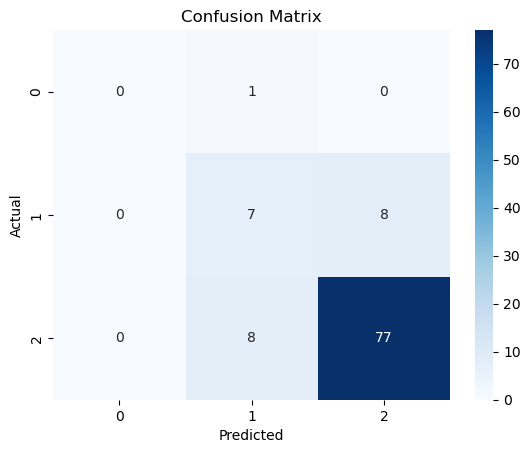

In [28]:
#  Classification Report and Confusion Matrix
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Cross-Validation for Model Stability

This section assesses the model’s robustness and consistency using **5-fold Stratified Cross-Validation**.

**Steps:**
1. Use `StratifiedKFold` to maintain class balance across folds.  
2. Evaluate the model with `cross_val_score` using accuracy as the metric.  
3. Print individual fold accuracies and summarize the mean and standard deviation.

**Output:**  
Displays per-fold accuracy scores and the overall mean ± standard deviation to gauge model stability.


In [29]:
# 2. Cross-Validation for Stability 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print(f" Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

 Cross-validation accuracy scores: [0.89108911 0.81188119 0.84158416 0.92       0.87      ]
Mean CV Accuracy: 0.8669 ± 0.0376


## ROC-AUC Curve Analysis

Here we visualize the model’s discriminatory power using **ROC-AUC curves** for both binary and multiclass classification setups.

**Steps:**
1. Detect the number of target classes.  
2. For binary classification, plot a single ROC curve and compute the AUC score.  
3. For multiclass problems, binarize labels and plot per-class ROC curves, including a micro-average curve.  
4. Display the resulting ROC-AUC values to assess model performance across classes.

**Output:**  
- ROC curves plotted for binary or multiclass cases.  
- AUC scores printed per class (and overall micro-average).


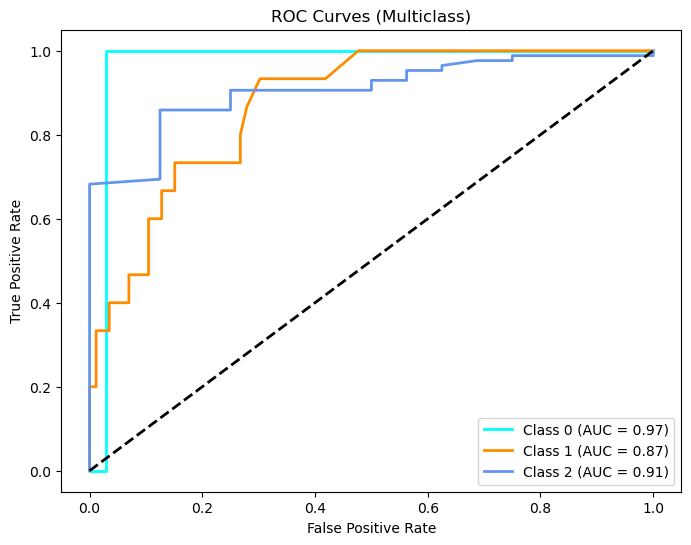

Per-class ROC-AUC: {0: 0.9700000000000001, 1: 0.8736434108527132, 2: 0.90625, 'micro': 0.9659347122831095}


In [30]:
#  3. ROC-AUC Curve 
# Check if multiclass
n_classes = len(np.unique(y_test))

# Handle binary vs multiclass ROC 
if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve (Binary)')
    plt.legend()
    plt.show()

else:
    # Multiclass handling
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_proba_bin = model.predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba_bin.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "red"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

    print("Per-class ROC-AUC:", roc_auc)


## Precision–Recall Curve Analysis

This section evaluates model precision versus recall for both **binary** and **multiclass** classifications.

**Steps:**
1. If binary, compute and plot a single Precision–Recall curve with AUC.  
2. For multiclass, binarize labels and calculate per-class Precision–Recall (PR) curves and Average Precision (AP).  
3. Compute a **micro-average PR curve** to summarize overall model performance.  
4. Visualize all class curves and print per-class and overall AP scores.

**Output:**  
- PR curves for each class and micro-average curve.  
- Average Precision (AP) values displayed per class and overall.


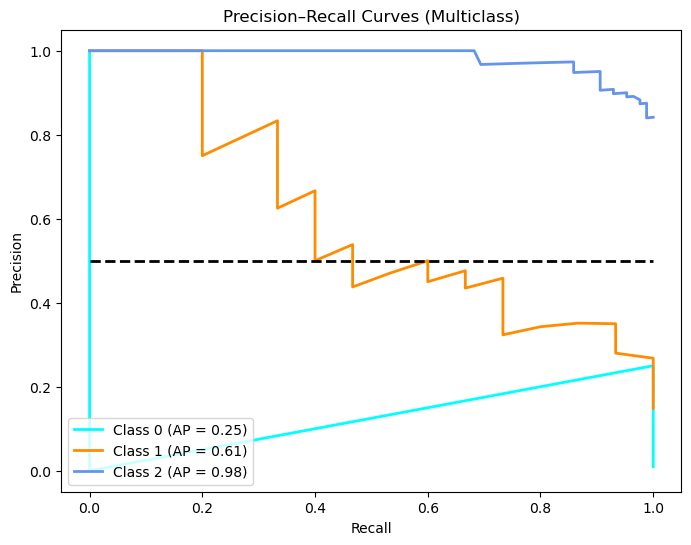

Per-class Average Precision (AP):
Class 0: AP = 0.250
Class 1: AP = 0.606
Class 2: AP = 0.982
Micro-average AP = 0.944


In [31]:
# Multiclass Precision-Recall Curves 
if n_classes == 2:
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    plt.figure()
    plt.plot(recall, precision, lw=2, color='navy', label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Binary)")
    plt.legend()
    plt.show()

else:
    # For multiclass classification
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_proba_bin = model.predict_proba(X_test)

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba_bin[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_proba_bin[:, i])

    # Compute micro-average precision-recall curve and area
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_test_bin.ravel(), y_proba_bin.ravel()
    )
    average_precision["micro"] = average_precision_score(y_test_bin, y_proba_bin, average="micro")

    # Plot all classes
    plt.figure(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "red"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f"Class {i} (AP = {average_precision[i]:.2f})")

    plt.plot([0, 1], [0.5, 0.5], "k--", lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves (Multiclass)")
    plt.legend(loc="lower left")
    plt.show()

    print("Per-class Average Precision (AP):")
    for i in range(n_classes):
        print(f"Class {i}: AP = {average_precision[i]:.3f}")
    print(f"Micro-average AP = {average_precision['micro']:.3f}")

## Feature Importance Visualization

This block displays the **top 5 most important features** in the trained Random Forest model.  
It helps identify which financial ratios contribute most to Z-Risk classification.

**Steps:**
1. Extract and sort feature importances from the trained model.  
2. Visualize the top five features using a horizontal bar chart.  
3. Interpret higher bars as stronger influence on model predictions.


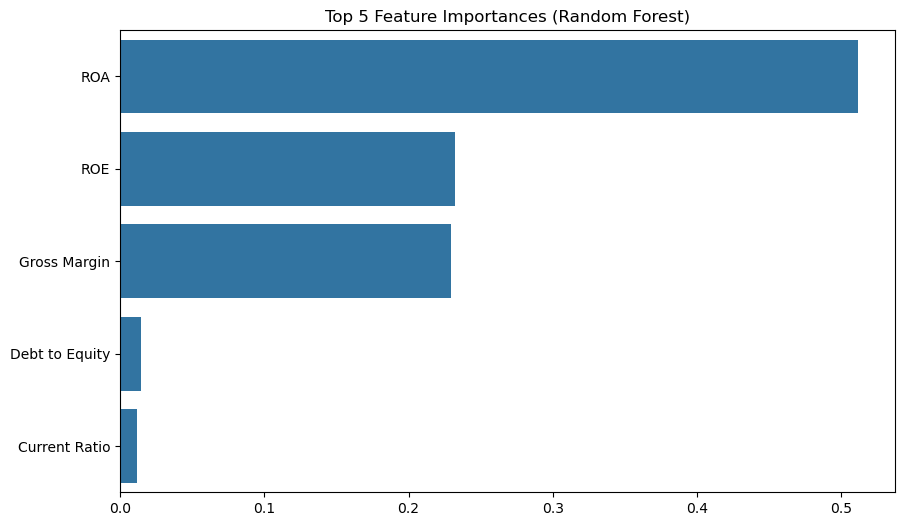

In [32]:
# Feature Importance 
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:5], y=np.array(X.columns)[indices][:5])
plt.title("Top 5 Feature Importances (Random Forest)")
plt.show()

## SHAP Feature Contribution Analysis

This section uses **SHAP (SHapley Additive exPlanations)** to interpret the Random Forest model’s predictions.  
It identifies how each input feature influences the output across all classes.

**Steps:**
1. Initialize a SHAP TreeExplainer for the trained Random Forest model.  
2. Compute SHAP values for the test set.  
3. For multiclass cases, sum absolute SHAP values across classes to gauge overall impact.  
4. Display a bar-based summary plot of feature contributions.

**Output:**  
A SHAP summary bar plot highlighting the most influential features driving classification decisions.


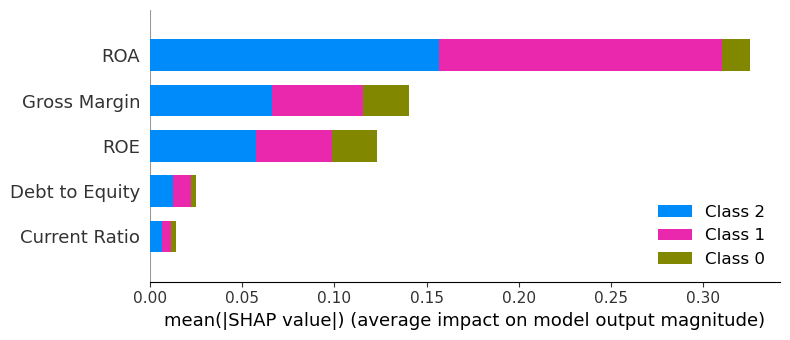

In [33]:

# Using SHAP for multiclass RandomForestClassifier
try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    if isinstance(shap_values, list):
        # For multiclass models, combine SHAP values across classes
        shap_values_sum = np.sum(np.abs(shap_values), axis=0)
        shap.summary_plot(shap_values_sum, X_test, plot_type="bar", show=True)
    else:
        # For binary models
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

except Exception as e:
    print(f" SHAP summary plot skipped due to: {e}")


## Environment Setup – Package Installation

This step ensures that all required libraries are installed for model persistence and web app deployment.

**Installed Packages:**
1. **joblib** – used for saving and loading trained models efficiently.  
2. **streamlit** – used for creating interactive web applications for visualizing and exploring results.


In [40]:
%pip install joblib
%pip install streamlit

Note: you may need to restart the kernel to use updated packages.



## Model Saving and Export

After training the XGBoost model, this block saves all essential components for deployment and later inference.

**Key Steps:**
- Creates a `models/` directory if it doesn’t exist.  
- Saves the trained **XGBoost model** using `joblib`.  
- Stores the **feature column list** required for future predictions.  
- Saves the **class mapping** for decoding model output labels.


In [43]:
import joblib
import os

# Create models directory
os.makedirs("models", exist_ok=True)

# Save XGBoost model
joblib.dump(xgb_model, "models/xgb_financial_health.pkl")
print("Model saved: models/xgb_financial_health.pkl")

# Save feature columns (important for prediction)
feature_columns = ['ROA', 'ROE', 'Current Ratio', 'Debt to Equity', 'Gross Margin']
joblib.dump(feature_columns, "models/feature_columns.pkl")
print("Feature columns saved")

# Save class mapping
class_mapping = {0: 'Safe', 1: 'Grey', 2: 'Distress'}
joblib.dump(class_mapping, "models/class_mapping.pkl")
print("Class mapping saved")

Model saved: models/xgb_financial_health.pkl
Feature columns saved
Class mapping saved


# Key Points & Summary of Work
The project successfully addressed the initial stages of the business objective: transforming raw financial data into actionable features for a scoring system.

* Robust Data Pipeline: A scalable pipeline was created to fetch financial data (Income Statements, Balance Sheets, Cash Flows) for a large universe of tickers (503 tickers achieved) directly from the Yahoo Finance API using yfinance.

* Data Standardization: A critical resolve_item_names function was implemented using fuzzy matching to reliably map inconsistent raw row names from the API (like "Total Revenues" or "Total Revenue") to standardized clean feature names.

Comprehensive Feature Set: Over 12 core financial features were engineered, covering the following pillars of financial health:

* Profitability Ratios: Gross Margin, Operating Margin, Net Margin, ROA, and ROE.

* Liquidity & Leverage Ratios: Current Ratio and Debt to Equity.

* Solvency Score: The Altman Z-Score was computed as a primary, multi-factor indicator of bankruptcy risk.

* Data Quality and Precision: All financial calculations utilized Python's Decimal type via a vec_safe_div function to ensure high arithmetic precision and prevent division-by-zero errors.

# Conclusions
Based on the data framework the following steps were done:

* Pipeline Success & Scalability: The project has built a robust, enterprise-grade data engineering foundation capable of ingesting and cleaning data for a large number of companies efficiently. This fulfills the requirement for a real-time, data-driven analysis tool.

* Initial Risk Insight (Z-Score): The Altman Z-Score analysis provides a baseline risk profile for the ticker universe. The statistics show a Mean Z-Score of 1.34 and a Median of 1.28. Since a Z-Score below 1.81 is classified as 'Distress', this suggests that, according to the Z-Score model, the average company in the sample exhibits significant financial distress risk.

* Data Quality Audit: The audit revealed a minimal number of unexpected negative values in fields like Gross Profit (1 instance) and Net Income (22 instances). The existence of these negative values is valid for loss-making companies but confirms the importance of the cleaning steps to prevent critical errors in ratio calculations.

# Recommendations
To achieve the remaining business objectives (creating the final scoring model, visualization, and actionable advice), the following steps are recommended:

* Complete the Scoring Model: The next critical step is to utilize the engineered features (ratios, Z-Score) to build the final Financial Health Scoring Model . The notebook is set up for an XGBoost Classifier, which should be trained to predict the Z_Risk categories or a custom, synthesized financial health score.

* Model Explainability: The project should leverage SHAP (already imported) to interpret the final model's predictions, ensuring the output is clear and explainable to both technical and non-technical users (a key success criterion). This will justify the final score.

* Build the Visualization Layer: Develop the planned clear dashboards and charts  to present the Z-Score distribution, key ratio trends over time, and the final predicted health score for each company, allowing for easier interpretation of financial health.

* Generate Actionable Advice: The final output should include logic to translate the resulting health score (e.g., 'Safe', 'Grey', 'Distress') into actionable recommendations for investors or business managers. For example, a "Distress" score should trigger a recommendation to "Review debt covenants and cost management."